## *CRISP-DM: Business Understanding*

Through this notebook we try to analyze the NFT market and identify the strategies which can aid a new buy/sell side player entering the NFT market.

In [1]:
import time
from typing import Sequence, Union, Optional, Any

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import nltk
import sklearn
import skopt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import reciprocal
import matplotlib.pyplot as plt

from nft_analyser.transformers import *
from nft_analyser import helper

Using TensorFlow backend.


Downgrade to sklearn==0.21.2 for RandomizedSearchCV with keras (known bug)

In [2]:
# Default Plotting Configuration
plt.style.use('seaborn-dark')
plt.rc('figure', figsize=(10, 7))
plt.rc('font', size=12)

## Data Configuration

| WARNING: The notebook relies on big data sources which are not part of this package. So, please download and specify the path to the data sources |
| --- |

### Data Sources:
* NFTs Transaction Database: https://www.kaggle.com/simiotic/ethereum-nfts
* Pre-trained GLOVE Dataset: https://nlp.stanford.edu/projects/glove/

In [3]:
data_paths = {
    "nft_sql": "/Users/gskgagan/Documents/workspace/nft/data/nfts.sqlite",
    # NOTE: It's glove_root and not the path, as the dataset has multiple files with varying number of features
    "glove_root": "/Users/gskgagan/Documents/workspace/nft/data/glove",
}

In [4]:
# Set the paths to the local data sources for use in helper functions
helper.set_config(data_paths)

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/gskgagan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gskgagan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gskgagan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## *CRISP-DM: Data Understanding*

## Q1. How accessible is the NFT market to new comers?

In [6]:
params = {
    'eth_to_usd': 3000,     # Min value asof 8th Jan 2022
    'wei_to_eth': 1e18      # Transaction data is present in WEI (Smallest denomination of Ether)
}

## Analyzing Existing NFTs and Players

#### NFTs Market Value Distribution

In [7]:
df = helper.get_table('current_market_values')
df['market_value'] = (df['market_value']/params['wei_to_eth'])*params['eth_to_usd']

In [8]:
qtiles = [v[0] for v in df.quantile(q=[0.0, 0.95, 1.0]).values]
df_normal = df[(df.market_value > qtiles[0]) & (df.market_value <= qtiles[1])]
df_big = df[(df.market_value > qtiles[1]) & (df.market_value <= qtiles[2])]

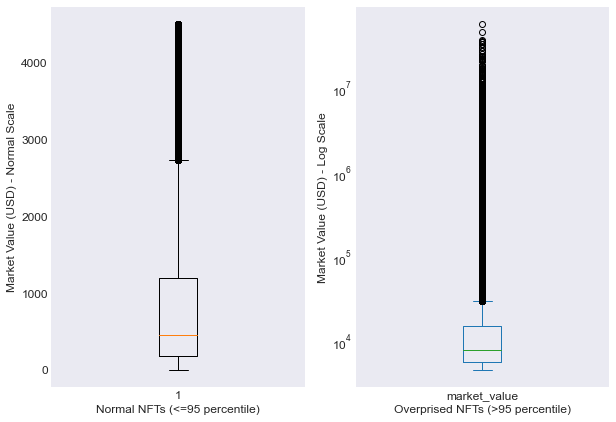

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

bp_data = ax1.boxplot(df_normal[['market_value']])
df_big.plot(kind='box', logy=True, ax=ax2)
ax1.set_xlabel('Normal NFTs (<=95 percentile)')
ax1.set_ylabel('Market Value (USD) - Normal Scale')
ax2.set_xlabel('Overprised NFTs (>95 percentile)')
ax2.set_ylabel('Market Value (USD) - Log Scale');

In [10]:
(q1, q1_minus), (q3, q3_plus) = [item.get_ydata() for item in bp_data['whiskers']]
median = bp_data['medians'][0].get_ydata()[0]
print(f'Q1-1.5*IQR: {round(q1_minus, 2)}, Q1: {q1}, Q3: {q3}, Q3+1.5*IQR: {q3_plus}')
print(f'Median: {median}')

Q1-1.5*IQR: 0.0, Q1: 180.0, Q3: 1200.0, Q3+1.5*IQR: 2730.0
Median: 450.0


* There's a good fraction of outliers are in the 10 million USD range. So, to do a fair assessment of a major chunk of NFT market distribution we just look till the 95 percentile values.
* About 25% of the NFTs are less than $180. Major fraction of the NFT market (i.e. less than 3rd Quartile) is under $1200.
* The Upper Whisker (corresponding to 3rd Quartile + 1.5xInter Quartile Range) is also less than $2800

**This means that there's relatively low barrier to entry when it comes to making investment in NFTs. *Better for a new player from the buy side***

**At the same time the value of significant number of NFTs is substantial. *Better for a new player entering from the sell side***

### Number of NFTs Held by Players

In [11]:
# NOTE: It's more efficient to directly set the query here instead of getting the table
df = pd.read_sql_query(
    f"""SELECT owner, count(nft_address) AS num_nfts
    FROM current_owners
    GROUP BY owner""",
    helper.conn
)

In [12]:
qtiles = [v[0] for v in df.quantile(q=[0.0, 0.99, 1.0]).values]
df_normal = df[(df.num_nfts > qtiles[0]) & (df.num_nfts <= qtiles[1])]
df_whales = df[(df.num_nfts > qtiles[1]) & (df.num_nfts <= qtiles[2])]

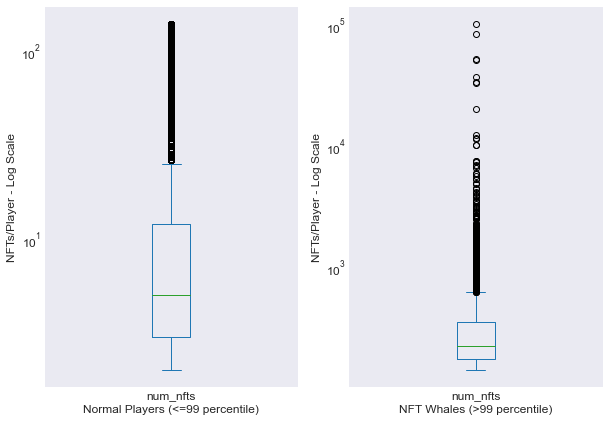

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

df_normal.plot(kind='box', logy=True, ax=ax1)
df_whales.plot(kind='box', logy=True, ax=ax2)
ax1.set_xlabel('Normal Players (<=99 percentile)')
ax1.set_ylabel('NFTs/Player - Log Scale')
ax2.set_xlabel('NFT Whales (>99 percentile)')
ax2.set_ylabel('NFTs/Player - Log Scale');

* A large fraction of players (99 percentile) hold reasonable number of NFTs (~100). With the third quartile being at about 10 NFTs.
* There are some big whales who hold more than 1000s of NFTs. Some even hold 100,000 NFTs.

**Looking at the large fraction of player base we can say that one doesn't have to hold a huge number of NFTs to be a player in the NFT marketplace. *Better for new players from the Buy side***

### NFT Mint Hold Times

In [14]:
df = helper.get_table('mint_holding_times')
df = df.set_index('days')

In [15]:
total_nfts = df['num_holds'].sum()
percentages = [50, 75, 90, 95, 99]
cum_df = df.cumsum()
num_days = [(cum_df - total_nfts*p/100).abs().sort_values(by='num_holds').index[0] for p in percentages]

Text(0.5, 0, 'Post mint hold period (days)')

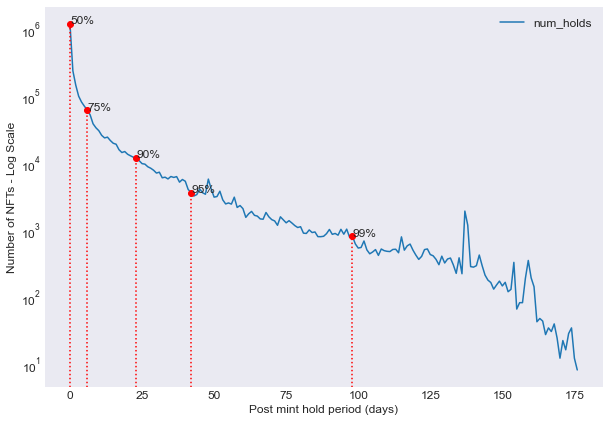

In [16]:
plt.figure()
ax = plt.gca()
df.plot(logy=True, ax=ax)
ax.stem(num_days, df.loc[num_days].values, linefmt='r:', markerfmt='ro')
for p, x, y in zip(percentages, num_days, df.loc[num_days].values):
    ax.text(x, y, f'{p}%')
ax.set_ylabel('Number of NFTs - Log Scale')
ax.set_xlabel('Post mint hold period (days)')

* Form the graph we can see that more than 50% of the newly minted NFTs enter a transaction the same day. This can be attributed to algorithmically generated NFTs which gets sold as they're minted.
* From the red percentage dots we can also see that more than in less than 25 days more than 90% NFTs minted are sold (with 99% NFTs sold in less than 100 days). Attributing the fact that, for a large majority of NFTs the market is very active.

**Newly minted NFTs are sold really quickly. *Better for new players from the sell side***

## Summary Q1
Based on the 3 graphs shown above, we can infer the following:
* **Buy Side:** A typical player in the NFT market holds NFTs with a median value of $450. Most of the players holding about 10 NFTs. So, to become a trader in the NFT market, one doesn't need a large capital investment.
* **Sell Side:** The combination of lucrative market value for most NFTs along with low hold duration (<25 days for 90% NFTs) for newly minted NFTs signify that the NFT market is highly liquid. So, creators should consider entering the NFT market.

# Semantic Model For Identifying NFT Values

Through the last question we identified that the NFT market doesn't have huge barriers to entry for both new buyers and new sellers. Now we focus our attention on semantic strategies which these players can apply to buy more profitable NFTs and sell NFTs with more attractive names.

In [17]:
default_params = {
    'glove_features': 300,                          
    'nft_value_range': [q1_minus, q3_plus],         
    'value_aggregation': ['median'],              
    'include_nft_age': True,                        
    'fill_na_age': 'max',                           
    'learning_rate': 0.8,
    'epochs': 100,
    'SearchCV': None
}

Notes on the default parameters:
* glove_features (300) - We tested with lower dimensions of Glove data, but the semantic relationship b/w words was not clear.
* nft_value_range (q1_minus, q3_plus) - Using the whiskers form the first analysis as this is associated with region of our target audience.
* value_aggregation (median) - There are several unique NFTs within a given name. We represent the NFT value by median, as mean is impacted by outliers.
* include_nft_age (True) - Should we include the NFT age in our analysis? Takes long time (10% out of sample improvement). Logic is, older NFTs might be more valuable by virtue of being present in the market for longer.
* fill_na_age (max) - There are some NFTs with no age. What should we do with them. Filling max as we don't have sufficient data to afford dropping.
* learning_rate (0.8) - Just the default learning rate for Deep Neural Network. Below we tried GridSearchCV and RandomizedSearchCV with numerous combination of this parameter.
* epochs (100) - We don't train for all 100 epochs. We have employed early stopping based on stable performance on the validation data set.
* SearchCV (Grid) {'Grid', 'Random', None} - To choose between GridSearchCV or RandomizedSearchCV or just the optimal parameters determined from their combination for quick analysis, for finding optimal parameters for our neural network.

## *CRISP-DM: Data preparation*

### Vector representation of NFT names using pretrained Glove

* We don't have enough data to properly train a word embedding model from scratch. 
* Also, as our end goal, we're interested in identifying semantically similar names for our NFT which won't be possible with using NFT names which don't have to convey meaning. 
* To alleviate this issue we use a Glove model output pre-trained on 6 billion tokens of Wikipedia and [Gigaword](https://catalog.ldc.upenn.edu/LDC2011T07) data.

In [18]:
# Input Data
nft_df = helper.get_table("nfts")
glove_df = helper.get_glove(features=default_params['glove_features'])

In [19]:
nft_vec_pp: Pipeline = Pipeline([
    ('selectColumns', SelectColumns(columns='name', index='address')),
    ('onlyFirstCapital', CamelCaseFirstCapital()),
    ('camelToWords', CamelCaseToWords()),
    ('cleanText', CleanText(regex=r'[^a-zA-Z0-9\$\#]')),
    ('tokenize', Tokenize()),
    ('removeStopWords', RemoveStopWords(nltk.corpus.stopwords.words('english'))),
    ('lemmatize', Lemmatize(lemmatizer=nltk.WordNetLemmatizer())),
    ('explodeList', ExplodeList()),
    ('gloveFeatures', Vectorize(column='name', vectorization_df=glove_df, ignore_missing=True))
])

In [20]:
# # NOTE: AIKIT has many great features related to pipelines, but the package isn't up to date.

# from aikit.pipeline import GraphPipeline

# nft_vec_pp: GraphPipeline = GraphPipeline([
#     ('selectColumns', SelectColumns(columns='name', index='address')),
#     ('onlyFirstCapital', CamelCaseFirstCapital()),
#     ('camelToWords', CamelCaseToWords()),
#     ('cleanText', CleanText(regex=r'[^a-zA-Z0-9\$\#]')),
#     ('tokenize', Tokenize()),
#     ('removeStopWords', RemoveStopWords(nltk.corpus.stopwords.words('english'))),
#     ('lemmatize', Lemmatize(lemmatizer=nltk.WordNetLemmatizer())),
#     ('explodeList', ExplodeList()),
#     ('gloveFeatures', Vectorize(column='name', vectorization_df=glove_df, ignore_missing=True))
# ])

In [21]:
# Below won't work with older version of sklearn. It's just a visual stuff, so can be ignored.
sklearn.set_config(display='diagram')
nft_vec_pp

Pipeline(steps=[('selectColumns',
                 SelectColumns(columns=['name'], index='address')),
                ('onlyFirstCapital', CamelCaseFirstCapital()),
                ('camelToWords', CamelCaseToWords()),
                ('cleanText', CleanText(regex='[^a-zA-Z0-9\\$\\#]')),
                ('tokenize', Tokenize()),
                ('removeStopWords',
                 RemoveStopWords(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you'...
zsombor    -0.408110  0.313380 -0.430250  0.069798 -0.207690  0.075486   
sandberger -0.130981 -0.142839 -0.175458 -0.168996 -0.022512  0.289750   

                 299       300  
0                               
the        -0.209890  0.053913  
,          -0.122260  0.354990  
.          -0.022394  0.136840  
of         -0.291830 -0.046533  
to          0.046744 -0.070621  
...              ...       ...  
chanty     -0.369570 -0.287180  
kronik      0.410210 -0.393080  
rolonda     0.309670  0.437610  
zsombor     0.284080 -0.175590  
sandberger  0.326180 -0.059053  

[400000 rows x 300 columns]))])

The pipeline above describes the steps needed to obtain vector representation of NFT names. These steps are needed to clean the NFT names and before they can be vectorized using Glove dataset.
The components of pipeline are:
* SelectColumns class just helps in specifying the columns we're interested in. Could've easily done it using `nft_df.set_index(index_name)[columns_list]` but we want to be true users of pipelines, so we're using a transformer to help us take care of this task. Do note that we're also setting index as the NFT address which will be used later to link addresses to the market values.
* Converting camel case words (AnotherBrickInTheWall) to a list of words split by the camel case (Another Brick In The Wall). This is needed as there's no semantic meaning for the single camel case word, but we can infer meaning from the individual words. This is handled by CamelCaseToWord class.
* There are also cases where there's a mixture of camel case and all caps words (AnotherBRICKInTheWall). This needs to be converted to AnotherBrickInTheWall, so that the above transformer (i.e. CamelCaseToWord) can break it appropriately. This is handled by CamelCaseFirstCapital class.
* CleanText class helps with selecting just alpha numeric characters and the \$ & \# signs for analysis. We ignore other characters to overlap with the kind of words we want to analyze using the glove data set we choose (which is based off english). Also, as we're aiming for human understandable semantic meanings, we don't want to use special characters (except \$ & \# signs as they have an understandable meaning) for our analysis.
* Tokenize, RemoveStopWords, Lemmatize classes helps with making our names ready for NLP analysis.
* ExploreList just converts form a list of words per NFT row to one row per word, so that it can be easily vectorized using the Glove dataset.
* Vectorize class finally consumes these NFT names broken down into individual words to finally convert them to float vectors.

In [22]:
# We simply call fit_transform on the input nft data to get the finalized vector form
nft_vec_df = nft_vec_pp.fit_transform(nft_df)

### Linking NFT vector to Transaction Data

In [23]:
# Transaction Data
trans_df = helper.get_table('transfers')
df = trans_df[['nft_address', 'transaction_value']]
df['transaction_value'] = df.transaction_value * params['eth_to_usd'] / params['wei_to_eth']   # To USD
# We filter a specific range of market values as we don't want to be impacted by outliers
df = df[(df.transaction_value > default_params['nft_value_range'][0]) & 
        (df.transaction_value < default_params['nft_value_range'][1])]       
transaction_df = df.groupby('nft_address').agg({'transaction_value': default_params['value_aggregation']})
transaction_df.columns = [c[1] for c in transaction_df.columns]         # Multiindex to simple columns

In [24]:
# Analysis Data - NFT vectors to transaction values
analysis_df = transaction_df.join(nft_vec_df, how='inner')
if default_params['include_nft_age']:
    time_df = helper.get_table('mints')
    time_df = time_df[['nft_address', 'timestamp']]
    time_df = time_df.groupby('nft_address').min()
    time_df = (time.time() - time_df) / (3600*24)       # Convert to days old asof today. Today can be anything as we'll reset to to 0 below
    analysis_df = analysis_df.join(time_df)
    if default_params['fill_na_age'] is None:
        analysis_df = analysis_df.dropna()
    elif default_params['fill_na_age'] is 'min':
        analysis_df = analysis_df.fillna(analysis_df.timestamp.min())
    else:
        analysis_df = analysis_df.fillna(analysis_df.timestamp.max())
    analysis_df['timestamp'] = analysis_df['timestamp'] - analysis_df['timestamp'].min()    # Resetting the age from the newest NFT (shouldn't matter much in the model)

## *CRISP-DM: Modeling*

### Fitting Neural Network

In [25]:
# Neural Network Definition
def hyper_neural_network(input_shape:int, output_shape:int, num_layers:int, num_neurons:int, connect_input:bool, 
                         loss_fn:str, learning_rate:float) -> keras.Model:
    """Neural network generating function taking in multiple hyperparaemters to determine the shape of the neural network.

    Args:
        input_shape (int): Shape of the input neuron.
        output_shape (int): Shape of the output neuron.
        num_layers (int): Number of intermediate layers.
        num_neurons (int): Number of layers per intermediate layer.
        connect_input (bool): Weather to connect the input neuron to the output neuron. There might be straight forward relevant features which are useful.
        loss_fn (str): Specifying the loss function to use during optimization.
        learning_rate (float): Learning rate of the neural network.

    Returns:
        keras.Model: Neural network described by the hyperparameters.
    """
    input_ = keras.layers.Input(shape=(input_shape,))
    last_ = input_
    for _ in range(num_layers):
        last_ = keras.layers.Dense(num_neurons, activation='relu')(last_)
    if connect_input:
        last_ = keras.layers.Concatenate()([input_, last_])
    output_ = keras.layers.Dense(output_shape, activation='relu')(last_)    # Positive $ values only
    
    model = keras.Model(inputs=[input_], outputs=[output_])
    model.compile(loss=loss_fn, optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model

Generate training, testing and validation datasets

Validation dataset is used to determine condition for early stopping

In [26]:
y_cols = default_params['value_aggregation']
X, y = analysis_df[[c for c in analysis_df.columns if c not in y_cols]], analysis_df[y_cols]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42, shuffle=True)
train_t, val_t, test_t = (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [27]:
# Performing Parameter Search on Neural Network
input_shape, output_shape = train_t[0].shape[1], train_t[1].shape[1]

model_reg = keras.wrappers.scikit_learn.KerasRegressor(hyper_neural_network,
                input_shape=input_shape, output_shape=output_shape, 
                num_layers=3, num_neurons=30, connect_input=True,
                loss_fn='mae', learning_rate=default_params['learning_rate'])

In [28]:
# NOTE: There's a known error with RandomizedSearchCV and keras on a newer version of sklearn. 
# Should be fixed by using tuples, but if not then use sklearn==0.21.2 if error occurs after a few runs.
# Issue: https://stackoverflow.com/questions/59746974/cannot-clone-object-tensorflow-python-keras-wrappers-scikit-learn-kerasclassifi
if default_params['SearchCV'] == 'Randomized':
    params_dist = {
        'num_layers': (1, 2, 3, 4),
        'num_neurons': tuple(np.arange(1, 100, 5)),
        'connect_input': (True, False),
        'learning_rate': reciprocal(3e-4, 3e-2)     # Faster
        # 'learning_rate': skopt.space.space.Real(10**-5, 10**0, "log-uniform", name='learning_rate')
    }
    search_cv = RandomizedSearchCV(model_reg, params_dist, n_iter=10, cv=3)        
    search_cv.fit(*train_t, epochs=default_params['epochs'], 
                        validation_data=val_t,    # Used for early stoppage
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])

The GridSearchCV parameters below are based off optimal parameters from RandomizedSearchCV. So this can ideally be run on it own.

But for any new training, you should first run RandomizedSearchCV to find optimal parameters. And then search around that space with GridSearchCV.

Optimal Parameters form RandomizedSearchCV:
* ``{'connect_input': True, 'learning_rate': 0.0006522209861537146, 'num_layers': 4, 'num_neurons': 56}``
* Best Score: -374.57564888032846

Optimal Parameters from GridSearchCV:
* ``{'connect_input': True, 'learning_rate': 6.522209861537146e-05, 'num_layers': 5, 'num_neurons': 65}``
* Best Score: -371.7387464864664

In [29]:
if default_params['SearchCV'] == 'Grid':
    params_dist = {
        'num_layers': [4, 5],        
        'num_neurons': [56, 65],
        'connect_input': [True, False],
        'learning_rate': [0.0006522209861537146*(10**i) for i in range(-1, 1+1)]
    }
    search_cv = GridSearchCV(model_reg, params_dist, cv=3)        
    search_cv.fit(*train_t, epochs=default_params['epochs'], 
                        validation_data=val_t,    # Used for early stoppage
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [30]:
if default_params['SearchCV'] is None:      # Here we're just choosing the optimal parameters as determined above
    params_dist = {
        'num_layers': [5],
        'num_neurons': [65],
        'connect_input': [True],
        'learning_rate': [0.0006522209861537146*(10**i) for i in range(-1, 0)]
    }
    search_cv = GridSearchCV(model_reg, params_dist, cv=3)        
    search_cv.fit(*train_t, epochs=default_params['epochs'], 
                        validation_data=val_t,    # Used for early stoppage
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])

2022-01-23 15:46:24.364209: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-23 15:46:24.365685: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


Train on 4184 samples, validate on 698 samples
Epoch 1/100
4184/4184 [==============================] - 2s 572us/step - loss: 496.7121 - val_loss: 520.2904
Epoch 2/100
4184/4184 [==============================] - 2s 373us/step - loss: 482.0166 - val_loss: 488.4201
Epoch 3/100
4184/4184 [==============================] - 2s 380us/step - loss: 426.6850 - val_loss: 414.0818
Epoch 4/100
4184/4184 [==============================] - 2s 394us/step - loss: 388.8253 - val_loss: 405.7081
Epoch 5/100
4184/4184 [==============================] - 2s 376us/step - loss: 386.5139 - val_loss: 404.6967
Epoch 6/100
4184/4184 [==============================] - 2s 404us/step - loss: 385.2995 - val_loss: 402.9548
Epoch 7/100
4184/4184 [==============================] - 2s 381us/step - loss: 383.7752 - val_loss: 401.2198
Epoch 8/100
4184/4184 [==============================] - 2s 390us/step - loss: 382.4067 - val_loss: 399.3462
Epoch 9/100
4184/4184 [==============================] - 2s 469us/step - loss: 38

In [31]:
print("Best Params:")
print(search_cv.best_params_)
print(f"Best Score: {search_cv.best_score_}")

Best Params:
{'connect_input': True, 'learning_rate': 6.522209861537146e-05, 'num_layers': 5, 'num_neurons': 65}
Best Score: -366.22339289259804


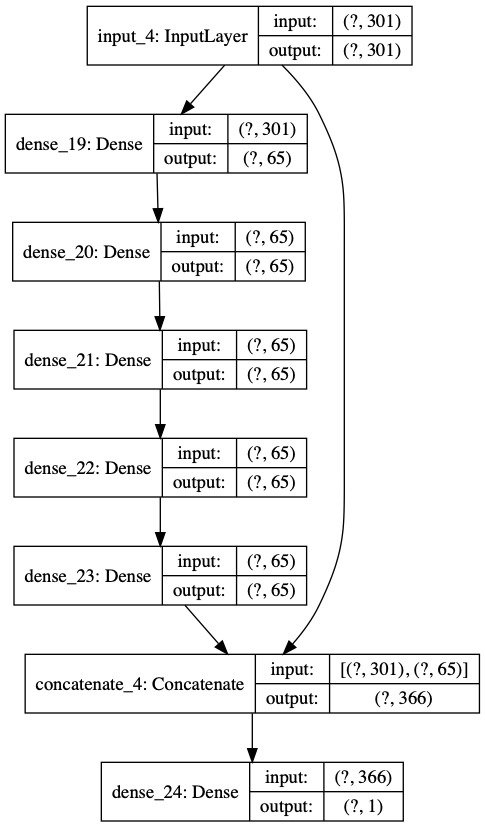

In [32]:
best_model = search_cv.best_estimator_.model
tf.keras.utils.plot_model(best_model, show_shapes=True)

## *CRISP-DM: Deployment*

## Name Comparison Class

The class seems straight forward for an important reason. We're using both the NFT names to Vector pipeline along with fitted neural network to perform the comparison analysis. This simplification makes the class's function simple to understand and heavily rely on the invariants set during creating the pipeline and neural network.

In [33]:
class CompareNames:
    """Class used to do comparison of different NFT words to find the ones which can have higher market value to aid in buying NFTs.
    The class also helps in providing semantically similar word recommendation for a given word which might have higher market value to aid in creating NFTs.
    """
    def __init__(self, vec_pp: Pipeline, pred_model: keras.Model, glove_df: pd.DataFrame, include_age: bool):
        """Initialize CompareName instance.

        Args:
            vec_pp (Pipeline): Pipeline used to clean any input NFT names and get their vector representation.
            pred_model (keras.Model): Neural Network model used to predict market value of a vectorized name.
            glove_df (pd.DataFrame): Glove DataFrame used to vectorize NFT names and find semantically similar names.
            include_age (bool): Weather or not age was used in the neural network.
        """
        self.vec_pp = vec_pp
        self.pred_model = pred_model
        self.glove_df = glove_df
        self.glove_set = set(glove_df.index)
        self.include_age = include_age

    def _get_vec_df(self, words: Sequence[str], include_age: bool=False) -> pd.DataFrame:
        """Vectorize NFT name's words.

        Args:
            words (Sequence[str]): Words to be used in NFT.
            include_age (bool, optional): If age was included in the neural network. Defaults to False.

        Returns:
            pd.DataFrame: Vectorized words as DataFrame.
        """
        df = pd.DataFrame({'name': words}, index=words)
        df = self.vec_pp.transform(df)
        if include_age:
            df['timestamp'] = 0.0
        return df
    
    def get_value(self, words: Sequence[str]) -> pd.DataFrame:
        """Get estimated value of a given sequence of words.

        Args:
            words (Sequence[str]): Sequence of words.

        Returns:
            pd.DataFrame: Value corresponding to the given sequence of words.
        """
        df = self._get_vec_df(words, self.include_age)
        return pd.DataFrame(self.pred_model.predict(df), index=df.index, columns=['est_value'])
        
    def get_similar(self, words: Sequence[str], limit: int=10) -> pd.DataFrame:
        """Get words similar to a given words. Uses Glove dataset to calculate the Euclidean distance for similarity.

        Args:
            words (Sequence[str]): Words whose similar words are needed.
            limit (int, optional): Number of similar words needed. Defaults to 10.

        Returns:
            pd.DataFrame: Words similar to a given word.
        """
        df = self._get_vec_df(words)
        sim_score_df = self.glove_df @ df.T
        return sim_score_df.apply(lambda col_ss: col_ss.sort_values(ascending=False)[:limit].index.values)

    def get_similar_value(self, words: Sequence[str], limit: int=10) -> pd.DataFrame:
        """Gives words similar to given words ranked by their relative market value. Uses Glove Euclidean distance under the hood.

        Args:
            words (Sequence[str]): Words whose similar words are needed.
            limit (int, optional): Number of similar words needed. Defaults to 10.

        Returns:
            pd.DataFrame: Words similar to given words ranked by their relative market value.
        """
        sim_df = self.get_similar(words, limit=limit)
        res_sss = {}
        for c in sim_df.columns:
            res_sss[c] = self.get_value(sim_df[c].values).sort_values(ascending=False, by='est_value').index
        res_df = pd.DataFrame(res_sss)
        res_df.index = pd.Index(data=range(1, limit+1), name='rank')
        return res_df

## Q2. Out of a bunch of available NFTs, which one should you buy?

Combination of vectorization pipeline and trained neural network helps us in answering this question.
We select a random sample of possible NFT names to get their relative value. Based on the relative values one can prefer buying one NFT over the other.

In [40]:
compare = CompareNames(nft_vec_pp, best_model, glove_df, default_params['include_nft_age'])
words = ['Fruit', 'Apple', 'Mango', 'Banana']
compare.get_value(words).sort_values('est_value', ascending=False)

,est_value
Apple,577.166260
Mango,363.388489
Fruit,321.850098
Banana,245.449173


In [41]:
words = ['Animal', 'Cat', 'Dog', 'Ape']
compare.get_value(words).sort_values('est_value', ascending=False)

,est_value
Animal,343.769684
Cat,297.207642
Ape,282.894196
Dog,266.858490


* Apple seems to dominate the fruits options. The reason could be attributed to the fact that semantically Apple is also associated with tech words, which could've found meaning over the NFT data available to us.
* From this small comparison set we can see that cats are not only popular on the internet, but their novelty has also extended to the NFT market.

## Q3. Given you're trying to create a new NFT, what semantic similar name could be the most popular?

Here we first get semantically similar names to the input names using the Glove dataset. Then we simply apply our Vectorizaiton pipeline along with neural network to get the final expected values. We simply order these alternative names based on their relative values to obtain this list of preferred alternative names.

In [42]:
words = ['Fruit', 'Apple', 'Mango', 'Banana', 'Animal', 'Cat', 'Dog', 'Ape']
compare.get_similar_value(words, limit=10)

,Fruit,Apple,Mango,Banana,Animal,Cat,Dog,Ape
rank,,,,,,,,
1,apples,iphone,guava,avocado,meat,leopard,animal,homo
2,juice,ipad,tomato,mango,animal,pet,terrier,tarzan
3,fruit,google,avocado,pineapple,animals,cat,pet,chimpanzee
4,fruits,ipod,chutney,papaya,livestock,cats,cat,ape
5,grapes,apple,mango,fruit,cattle,dog,dog,apes
6,grape,intel,apricot,peanut,human,dogs,dogs,gorilla
7,berries,microsoft,pineapple,coconut,humans,rabbit,hound,hairy
8,vegetables,itunes,papaya,sugar,poultry,horse,horse,frog
9,vegetable,macintosh,cucumber,banana,wildlife,monkey,puppy,creature


* Our assumption about Apple was correct. Also, apple as a NFT name stands at 5th place. Saying that using the name iPhone in your NFT would be more preferable than Apple. Also, just looking at Fruit, we also see that apple is highly ranked. So, it means that the name apple is favored by two semantic categories.
* On the cat side it seems like leopard might be a better option. The causation behind this will have to be investigated.
* An interesting find is around the word Dog. It seems that Cat (rank 4) is still a more popular name than Dog (rank 5).

**NOTE: It seems that for exploratory analysis this was a good project, but we need more data and metadata to be able to make a robust model. But never the less, it seems like a good first stab.**